# Loading the Corpus

In [1]:
target_url = "https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt"

In [2]:
import urllib
corpus = []
for line in urllib.request.urlopen(target_url).readlines():
    corpus.append(line.strip())

In [11]:
# Comment out this cell, to run the model on the shakespear dataset
corpus = ['cat chases mouse',
        'cat catches mouse',
        'cat eats mouse',
        'mouse runs into hole',
        'cat says bad words',
        'cat and mouse are pals',
        'cat and mouse are chums',
        'mouse stores food in hole',
        'cat stores food in house',
        'mouse sleeps in hole',
        'cat sleeps in house',
        'cat and mouse are buddies',
        'mouse lives in hole',
        'cat lives in house']

In [12]:
corpus[0]

'cat chases mouse'

### Preprocessing our Corpus

In [13]:
import re, html

def pad(line, context_window=4):
  pad_size = context_window // 2
  return ["<pad>" for i in range(pad_size)] + line + ["<pad>" for i in range(pad_size)]

def preprocess(line, context_window):
  if not isinstance(line, str):
    line = line.decode('utf-8')
  line = html.unescape(line).lower()
  line = re.sub('[^a-z]',' ', line)
  return pad(line.split(), context_window)


In [14]:
preprocess(corpus[5], 4)

['<pad>', '<pad>', 'cat', 'and', 'mouse', 'are', 'pals', '<pad>', '<pad>']

In [15]:
CONTEXT_WINDOW = 6
corpus_processed = [preprocess(line, CONTEXT_WINDOW) for line in corpus]

# Preparing Co-Occurrence Matrix

In [16]:
# First we need our vocabulary
vocab = {}
size = 0

for line in corpus_processed:
  for word in line:
    if word not in vocab:
      vocab[word] = size
      size += 1

rev_vocab = {i:word for word, i in vocab.items()}

In [17]:
vocab['mouse'], rev_vocab[3]

(3, 'mouse')

In [18]:
size

23

In [105]:
from collections import defaultdict
from tqdm import tqdm
CONTEXT_WINDOW = 6

X, y = [], []

for line in tqdm(corpus_processed):
  for i in range(CONTEXT_WINDOW // 2, len(line) - CONTEXT_WINDOW // 2):
    curr_word = line[i]
    prev_words = line[i-CONTEXT_WINDOW // 2:i]
    next_words = line[i+1: i+1+(CONTEXT_WINDOW // 2)]
    X.append([vocab[i] for i in prev_words + next_words])
    y.append(vocab[curr_word])

100%|██████████| 14/14 [00:00<00:00, 5147.74it/s]


In [106]:
X[:5]

[[0, 0, 0, 2, 3, 0],
 [0, 0, 1, 3, 0, 0],
 [0, 1, 2, 0, 0, 0],
 [0, 0, 0, 4, 3, 0],
 [0, 0, 1, 3, 0, 0]]

In [107]:
y[:5]

[1, 2, 3, 1, 4]

# Word2Vec Embedding Model

In [22]:
# CONSTANTS
VOCAB_SIZE = size
EMB_SIZE = 8
NUM_EPOCHS = 10

In [23]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [108]:
class Word2Vec(nn.Module):

    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
        )
        self.fc = nn.Linear(embedding_size, vocab_size)

    def forward(self, x):
        embds = self.word_emb(x)
        emb = torch.mean(embds, dim=1)
        out = self.fc(emb)
        return out

word2vec = Word2Vec(vocab_size=VOCAB_SIZE, embedding_size=EMB_SIZE)
word2vec = word2vec.to(device)

In [109]:
optimizer = torch.optim.Adam(word2vec.parameters(), lr=0.001)

In [110]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    return torch.LongTensor(self.X[idx]), torch.LongTensor([self.y[idx]])

  def __len__(self):
    return len(self.X)

dataset = CustomDataset(X, y)
train_dataset = DataLoader(dataset, batch_size=8, shuffle=True)

In [111]:
batch = next(iter(train_dataset))

In [120]:
word2vec.train()

loss_func = nn.CrossEntropyLoss()

losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
  epoch_loss = 0
  for X, y in train_dataset:
    X, y = X.to(device), y.to(device)
    output = word2vec(X)
    loss = loss_func(output, y.squeeze(dim=1))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_loss += loss.cpu().detach().item()

  losses.append(epoch_loss)
print(f"Epoch {epoch}: loss = {epoch_loss}")

100%|██████████| 10/10 [00:00<00:00, 68.27it/s]

Epoch 9: loss = 3.3023142516613007


In [121]:
word_vectors = word2vec.word_emb(torch.LongTensor([i for i in range(VOCAB_SIZE)]).to(device)).cpu().detach().numpy()

In [122]:
import pandas as pd

word_vectors = pd.DataFrame(word_vectors, columns=[f"f_{i}" for i in range(EMB_SIZE)])
word_vectors['word'] = [rev_vocab[i] for i in range(0, VOCAB_SIZE)]

In [123]:
word_vectors

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,word
0,-1.067397,-0.801663,-1.332825,1.015873,-0.902183,-0.245418,0.608063,-0.991950,<pad>
1,5.155348,3.876250,0.261261,-2.418043,0.437870,0.465762,2.436163,3.617084,cat
2,-1.559241,-2.174669,-1.384145,2.044338,2.503202,-3.054060,1.888509,-0.352399,chases
3,-3.267818,4.795168,2.291086,0.573898,-2.850217,1.131927,-3.155930,1.696312,mouse
4,-1.277344,-3.426071,-1.365879,0.884095,1.733199,-4.235494,2.297269,-1.856599,catches
5,-1.652216,-3.294243,-1.825176,2.506169,-0.239695,-3.938842,1.899568,-0.787619,eats
6,-2.081284,-0.991527,-2.824138,6.219646,3.111309,3.350767,0.195719,4.316447,runs
7,-0.572580,-3.827738,-2.566583,-1.857773,2.447538,-2.053251,-0.474032,1.734207,into
8,5.396008,3.136331,-1.476307,-3.636201,-3.398837,-2.878013,-2.151384,-2.437088,hole
9,-5.122947,2.646393,2.569002,-0.548096,-1.465672,0.519846,4.027491,-0.476111,says


In [124]:
from sklearn.decomposition import PCA

In [125]:
pca = PCA(2)

pca_vectors = pca.fit_transform(word_vectors.to_numpy()[:,:-1])

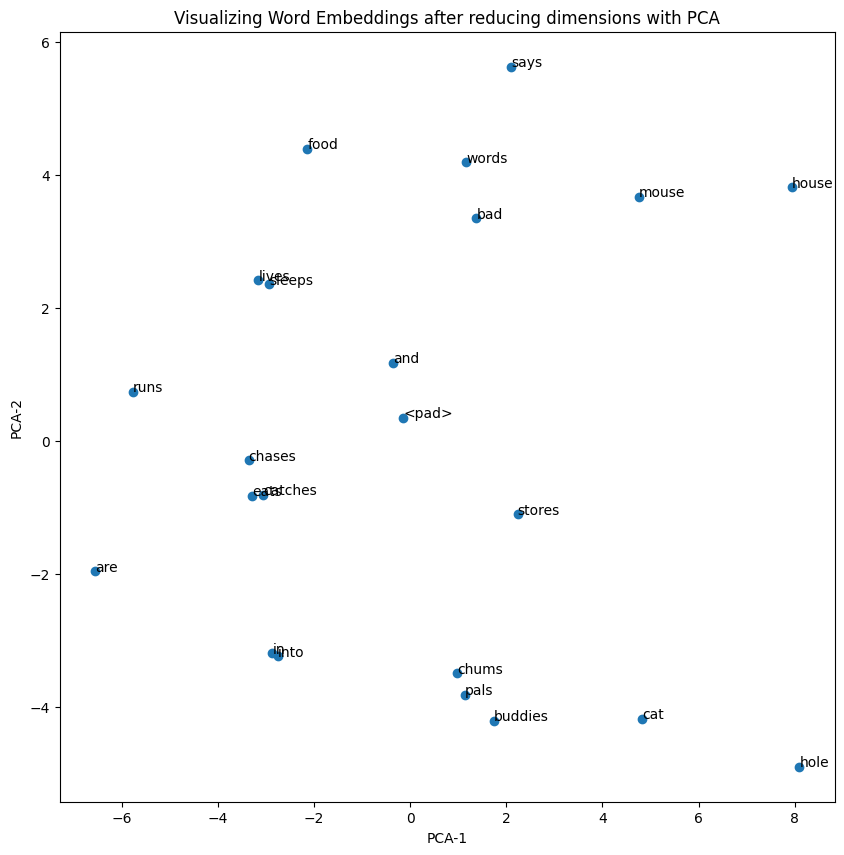

In [126]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(pca_vectors[:,0], pca_vectors[:,1])
for i, word in enumerate(word_vectors['word'].tolist()):
  x, y = pca_vectors[i]
  plt.annotate(word, (x, y))
plt.title("Visualizing Word Embeddings after reducing dimensions with PCA")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.show()